In [22]:
import numpy as np
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB

In [23]:
env = gp.Env(empty=True)
env.setParam("OutputFlag", 0)
env.start()

<gurobipy.Env, Parameter changes: OutputFlag=0>

In [24]:
def second_stage_solution_underloaded(c_reduced, a, x, b_true):
    n = len(c_reduced)  # Number of variables

    b_underload = b_true - sum(a[i] * x[i] for i in range(n))

    # Create a new model
    model = gp.Model("optimization_problem", env=env)

    # Create decision variables
    y_plus = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="y_plus")

    # Set objective function
    model.setObjective(
        sum(c_reduced[i] * y_plus[i] for i in range(n)), sense=GRB.MAXIMIZE
    )

    # Add constraints
    for k in range(n):
        model.addConstr(y_plus[k] <= 1 - x[k])

    model.addConstr(sum(a[i] * y_plus[i] for i in range(n)) <= b_underload)

    # Optimize the model
    model.optimize()

    # Retrieve the solution
    if model.status == GRB.OPTIMAL:
        optimal_solution = [y_plus[i].x for i in range(n)]
        optimal_objective = model.objVal
        return optimal_solution, optimal_objective
    else:
        # print("No solution found")
        return [0] * n, 0

In [181]:
def second_stage_solution_overloaded(d, x, a, b_true):
    n = len(x)  # Number of variables

    b_overload = sum(a[i] * x[i] for i in range(n)) - b_true

    # Create a new model
    model = gp.Model("optimization_problem", env=env)

    # Create decision variables
    y_minus = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="y_minus")

    # Set objective function
    model.setObjective(sum(d * y_minus[i] for i in range(n)), sense=GRB.MINIMIZE)

    # Add constraints
    for k in range(n):
        model.addConstr(y_minus[k] <= x[k])

    model.addConstr(sum(a[i] * y_minus[i] for i in range(n)) >= b_overload)

    # Optimize the model
    model.optimize()

    # Retrieve the solution
    if model.status == GRB.OPTIMAL:
        optimal_solution = [y_minus[i].x for i in range(n)]
        optimal_objective = model.objVal
        return optimal_solution, optimal_objective
    else:
        # print("No solution found")
        return [0] * n, 0

In [182]:
from scipy.stats import norm


def norm_cdf(x, mu, sigma):
    return norm.cdf(x, loc=mu, scale=sigma)

In [183]:
def first_stage_solution(c, a, b_stochastic):
    # print("xi: ", xi)

    n = len(c)  # Number of variables

    # Create a new model
    model = gp.Model("first_stage_problem", env=env)

    # Create decision variables
    x = model.addVars(n, vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")

    # Set objective function
    model.setObjective(sum(c[i] * x[i] for i in range(n)), sense=GRB.MAXIMIZE)

    # Add constraints
    model.addConstr(sum(a[i] * x[i] for i in range(n)) <= b_stochastic)

    # Optimize the model
    model.optimize()

    # Retrieve the solution
    if model.status == GRB.OPTIMAL:
        optimal_solution = [x[i].x for i in range(n)]
        optimal_objective = model.objVal
        return optimal_solution, optimal_objective
    else:
        return None

In [238]:
n = 10  # number of items in the knapsack
a = [3, 10, 5, 7, 4, 1, 6, 2, 8, 1]  # weights
c = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # values

b = 15  # capacity of the knapsack
nu = 0  # mean of the normal distribution
sigma = 10  # standard deviation of the normal distribution
epsilon = 7  # threshold for the normal distribution
d = 10  # cost of overloading the knapsack
c_redused = [c[i] / 2 for i in range(n)]  # cost of underloading the knapsack

N = 10000  # number of scenarios


def sample_average_approximation(a, c, b, nu, sigma, epsilon, d, c_redused, N):
    first_st_sol = []
    second_st_sol_un = []
    second_st_sol_ov = []
    xis = []

    distribution = norm(loc=nu, scale=sigma)

    true_xi = distribution.rvs()
    while abs(true_xi) > epsilon:
        true_xi = distribution.rvs()

    true_b = b + true_xi

    for i in range(N):
        xi = distribution.rvs()
        while abs(xi) > epsilon:
            xi = distribution.rvs()
        b_stochastic = b + xi

        x, obj = first_stage_solution(c, a, b_stochastic)
        y_plus, obj_plus = second_stage_solution_underloaded(c_redused, a, x, true_b)
        y_minus, obj_minus = second_stage_solution_overloaded(d, x, a, true_b)

        first_st_sol.append(obj)
        second_st_sol_un.append(obj_plus)
        second_st_sol_ov.append(obj_minus)
        xis.append(xi)
    return first_st_sol, second_st_sol_un, second_st_sol_ov, xis, true_xi

In [218]:
(
    first_st_sol,
    second_st_sol_un,
    second_st_sol_ov,
    xis,
    true_xi,
) = sample_average_approximation(a, c, b, nu, sigma, epsilon, d, c_redused, N)

In [219]:
true_xi

6.785710475669253

In [220]:
final_obj = []
for i in range(N):
    final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])

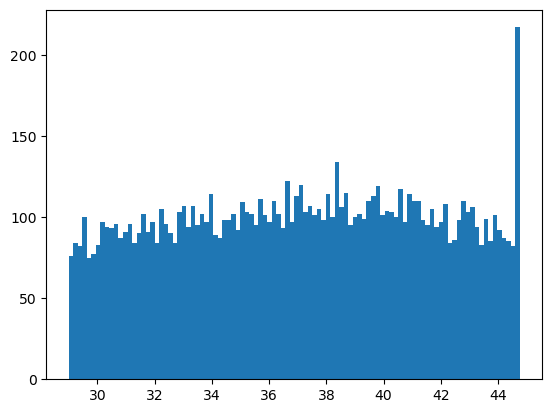

In [221]:
import matplotlib.pyplot as plt

plt.hist(final_obj, bins=100)
plt.show()

In [222]:
print("Mean: ", np.mean(final_obj))
print("Standard deviation: ", np.std(final_obj))
print("Minimum: ", min(final_obj))
print("Maximum: ", max(final_obj))

Mean:  37.098039109999185
Standard deviation:  4.471015584560811
Minimum:  29.00104378844516
Maximum:  44.758708066411074


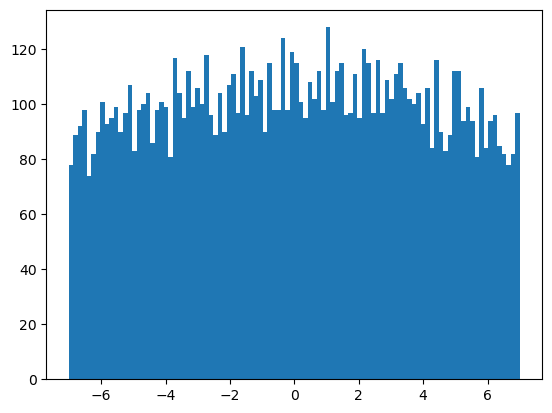

In [223]:
plt.hist(xis, bins=100)
plt.show()

In [224]:
max_arg = np.argmax(final_obj)
min_arg = np.argmin(final_obj)

In [225]:
xis[max_arg], xis[min_arg]

(6.787440225403994, -6.999105324189862)

In [226]:
max_xi = xis[max_arg]

In [239]:
x, obj = first_stage_solution(c, a, b + true_xi)
obj

32.98287327851308

In [275]:
def sample_average_approximation_robust(
    a, c, b, nu, sigma, epsilon, d, c_redused, N, polarity
):
    first_st_sol = []
    second_st_sol_un = []
    second_st_sol_ov = []
    xis = []

    distribution = norm(loc=nu, scale=sigma)

    true_xi = distribution.rvs()
    while abs(true_xi) > epsilon:
        true_xi = distribution.rvs()

    true_b = b + true_xi

    for i in range(N):
        xi = distribution.rvs()
        while abs(xi) > epsilon:
            xi = distribution.rvs()
        b_stochastic = b + xi

        if polarity == "underload":
            b_stochastic -= epsilon
        elif polarity == "overload":
            b_stochastic += epsilon
        else:
            raise NotImplemented

        x, obj = first_stage_solution(c, a, b_stochastic)
        y_plus, obj_plus = second_stage_solution_underloaded(c_redused, a, x, true_b)
        y_minus, obj_minus = second_stage_solution_overloaded(d, x, a, true_b)

        first_st_sol.append(obj)
        second_st_sol_un.append(obj_plus)
        second_st_sol_ov.append(obj_minus)
        xis.append(xi)
    return first_st_sol, second_st_sol_un, second_st_sol_ov, xis, true_xi

In [304]:
d = 10
c_redused = [-c[i] / 2 for i in range(n)]  # cost of underloading the knapsack

In [310]:
(
    first_st_sol,
    second_st_sol_un,
    second_st_sol_ov,
    xis,
    true_xi,
) = sample_average_approximation_robust(
    a, c, b, nu, sigma, epsilon, d, c_redused, N, "underload"
)
true_xi

1.898050105729058

In [311]:
final_obj = []
for i in range(N):
    final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])

In [312]:
print("Mean: ", np.mean(final_obj))
print("Standard deviation: ", np.std(final_obj))
print("Minimum: ", min(final_obj))
print("Maximum: ", max(final_obj))

Mean:  27.981716529752106
Standard deviation:  6.2643600642593515
Minimum:  10.002140785636687
Maximum:  37.12330302872257


In [313]:
x, obj = first_stage_solution(c, a, b + true_xi)
obj

39.260306368945194

In [309]:
(
    first_st_sol,
    second_st_sol_un,
    second_st_sol_ov,
    xis,
    true_xi,
) = sample_average_approximation_robust(
    a, c, b, nu, sigma, epsilon, d, c_redused, N, "overload"
)
true_xi

0.09738163447238496

In [301]:
final_obj = []
for i in range(N):
    final_obj.append(first_st_sol[i] + second_st_sol_un[i] - second_st_sol_ov[i])

In [302]:
print("Mean: ", np.mean(final_obj))
print("Standard deviation: ", np.std(final_obj))
print("Minimum: ", min(final_obj))
print("Maximum: ", max(final_obj))

Mean:  36.725982943742366
Standard deviation:  2.001926507039612
Minimum:  31.900190710672504
Maximum:  38.664528513596835


In [303]:
x, obj = first_stage_solution(c, a, b + true_xi)
obj

38.66467037395117